In [1]:
# Useful Python Packages
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from numba import njit

In [2]:
#Make plots larger
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

## Defining Constants

In [3]:
G = 6.675e-11 #Gravitational Constant
M = 2.0e+30 #Sun mass
m = 0.33e+24 #Mercury mass
c = 3.0e+8 #Speed of light

x0 = 69.8e+9 #Mercury aphelion
vy0 = 38.9e+3 #Mercury minimum orbital velocity (therefore velocity at aphelion)

a = 57.9e+9 #Mercury orbital semi-major axis
e = 0.2 #Mercury orbital eccentricity

## Functions

In [4]:
@njit
def solve(k):
    '''
    Simulate Mercury's orbit.
    
    k being 0 and 3, corresponds to Newtonian gravity and General Relativity respectively.
    Make k somewhat larger (10, 20, etc.) for better t vs theta graphs which can be extrapolated down to the real scenario.
    Make k tremendously larger (1e4, 1e5, etc.) for visible precession.
    '''
        
    def a_r(r, k, l):
        ''' Calculate radial acceleration '''
        return -G*M/r**2 - k*G*M*(l**2)/((c**2)*(r**4)) + l**2/r**3

    def a_theta(rd, r, l):
        ''' Calculate angular acceleration '''
        return -2*l*rd/r**3
    
    dt = 10 #Time step
    finalT = 1e9 #Final Time, equivalent to about 32 Earth years, or 133 Mercury years
    N = int(finalT/dt)
    
    t = np.zeros(N+1) #Time
    r = np.zeros(N+1) #Radial Position
    rd = np.zeros(N+1) #Radial Velocity
    theta = np.zeros(N+1) #Angular Position
    thetad = np.zeros(N+1) #Angular Velocity
    l = np.zeros(N+1) #Angular Momentum per Mass

    r[0] = x0
    rd[0] = 0.0
    theta[0] = 0.0
    thetad[0] = vy0/x0
    l[0] = x0*vy0
    
    for i in range(1, N+1):
        t[i] = t[i-1] + dt
        
        drhalf = rd[i-1] + 0.5*dt*a_r(r[i-1], k, l[i-1])
        dthetahalf = thetad[i-1] + 0.5*dt*a_theta(rd[i-1], r[i-1], l[i-1])
        
        r[i] = r[i-1] + dt*drhalf
        rd[i] = drhalf + 0.5*dt*a_r(r[i], k, l[i-1])

        theta[i] = theta[i-1] + dt*dthetahalf        
        thetad[i] = dthetahalf + 0.5*dt*a_theta(rd[i], r[i], l[i-1])
        
        l[i] = r[i]**2*thetad[i]
                             
    return r, theta, t

In [5]:
def peri(r, theta, t):
    ''' Find the perihelions' polar coordinates and the times at which they appear '''
    peris = find_peaks(-r)[0]
    peridis = r[peris]
    periang = (theta[peris])%(2*np.pi)
    periangmod = np.round(periang, 6) #Rounding the Angular Positions to 7 significant figures
    perit = t[peris]
    
    return peridis, periang, periangmod, perit

In [6]:
def perirate(m, perit):
    ''' Assuming the t v/s theta%2pi points form a straight line,
    Slope of polyfitted line (m) = Angle precessed in one orbit / Time between consecutive perihelions '''
    
    pr_per_o = m*(perit[1] - perit[0])*(180/np.pi)*3600 #Precession rate in arcseconds per orbit
    pr_per_c = pr_per_o*36525/88 #Precession rate in arcseconds per century
    
    return pr_per_o, pr_per_c

## Orbits (for Newtonian gravity and the GR correction term)

In [7]:
#Starting up njit for solve()
_, _, _ = solve(k=0)

In [8]:
%%time
rn, thetan, tn = solve(k=0) #Newtonian gravity
re, thetae, te = solve(k=3) #General Relativity

Wall time: 28.2 s


In [9]:
#Find perihelions for above orbits
prn, pthn, pthnm, ptn = peri(rn, thetan, tn) 
pre, pthe, pthem, pte = peri(re, thetae, te)

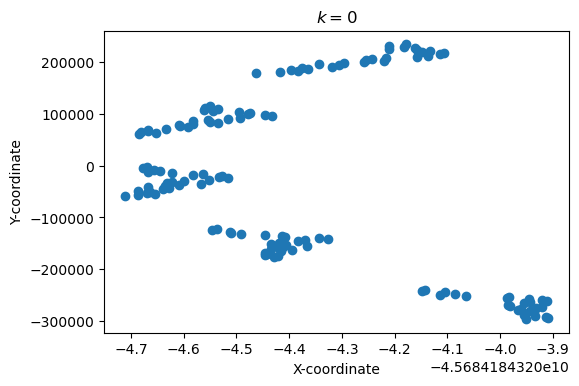

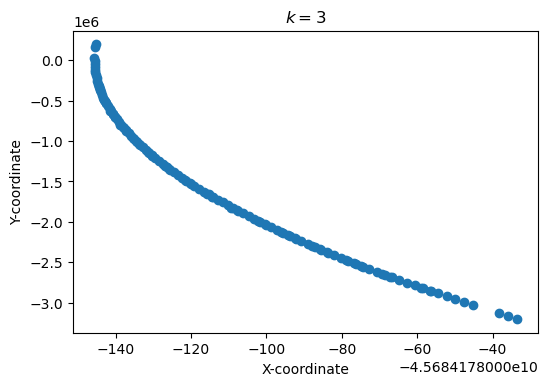

In [10]:
#Plotting the perihelions only

plt.scatter(prn*np.cos(pthn), prn*np.sin(pthn))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('$k=0$')
plt.show()

plt.scatter(pre*np.cos(pthe), pre*np.sin(pthe))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('$k=3$')
plt.show()

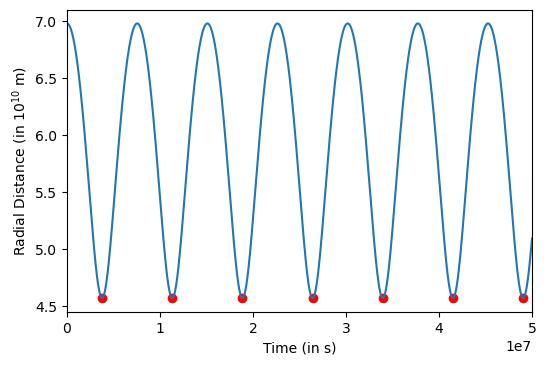

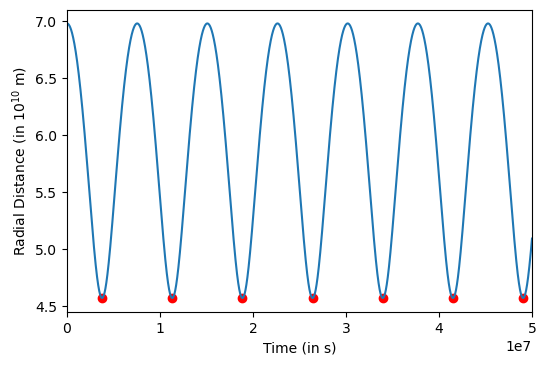

In [11]:
#Plotting the Radial Position against Time, for the entire orbit, and the perihelions

plt.plot(tn, rn/1e10)
plt.scatter(ptn, prn/1e10, color='red')
plt.xlim(0, 5e7)
plt.xlabel('Time (in s)')
plt.ylabel('Radial Distance (in 10$^{10}$ m)')
plt.show()

plt.plot(te, re/1e10)
plt.scatter(pte, pre/1e10, color='red')
plt.xlim(0, 5e7)
plt.xlabel('Time (in s)')
plt.ylabel('Radial Distance (in 10$^{10}$ m)')
plt.show()

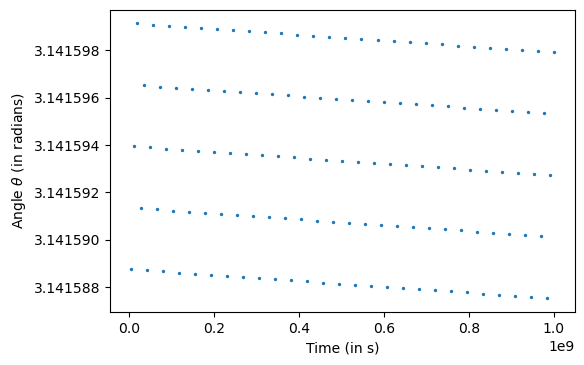

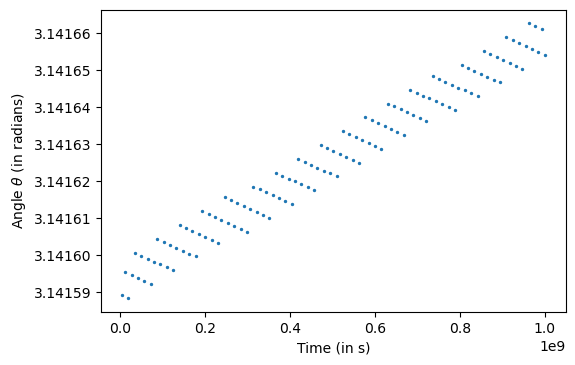

In [26]:
#Plotting the Angular Position (without rounding) against Time for the Perihelions

plt.scatter(ptn, pthn, s=2)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

plt.scatter(pte, pthe, s=2)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

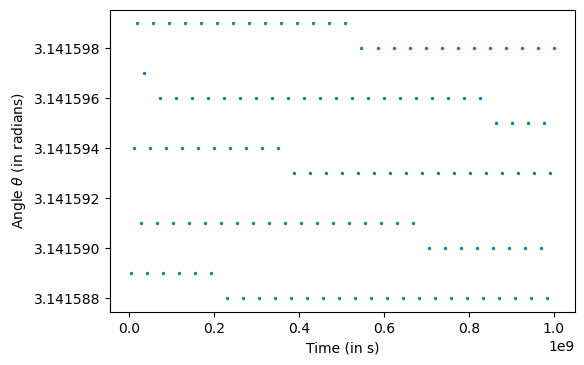

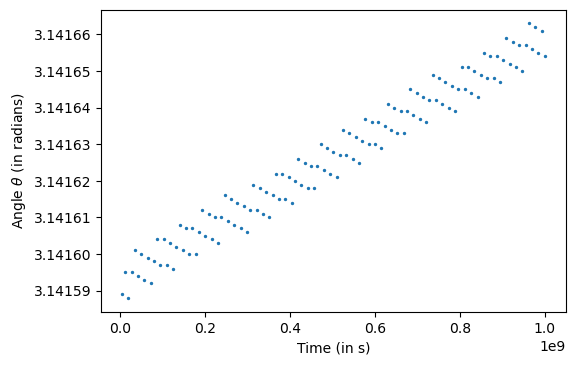

In [27]:
#Plotting the Angular Position (with rounding) against Time for the Perihelions'''

plt.scatter(ptn, pthnm, s=2)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

plt.scatter(pte, pthem, s=2)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

In [14]:
#Finding the best fit lines for the theta vs t graphs

mn, cn = np.polyfit(ptn, pthnm, 1)
me, ce = np.polyfit(pte, pthem, 1)

In [15]:
#Calculating the precession rates for each orbit

pon, pcn = perirate(mn, ptn)
poe, pce = perirate(me, pte)

In [16]:
print("In Newtonian gravity, Mercury's orbit precesses by", pcn, "arcseconds per century.")
print("With the GR correction term, Mercury's orbit precesses by", pce, "arcseconds per century.")

In Newtonian gravity, Mercury's orbit precesses by -0.6515572191807693 arcseconds per century.
With the GR correction term, Mercury's orbit precesses by 43.04907387466938 arcseconds per century.


# Increasing $k$

In [17]:
''' This cell takes a long time to run, and may kill the kernel. Uncomment and run with this knowledge in mind. '''
''' Try running this cell without running the section above this one. '''

# rp, thetap, tp = solve(k=3)
# xp, yp = rp*np.cos(thetap), rp*np.sin(thetap)

# rvp, thetavp, tvp = solve(k=50000)
# xvp, yvp = rvp*np.cos(thetavp), rvp*np.sin(thetavp)

' Try running this cell without running the section above this one. '

In [18]:
''' Uncomment and run only after same has been done to cell above. '''

# plt.scatter(0,0, color='orange')
# plt.scatter(xvp, yvp, s=1)
# plt.axis('equal')
# plt.xlabel('X-coordinate')
# plt.ylabel('Y-coordinate')
# plt.show()

' Uncomment and run only after same has been done to cell above. '

# Expected Graphs

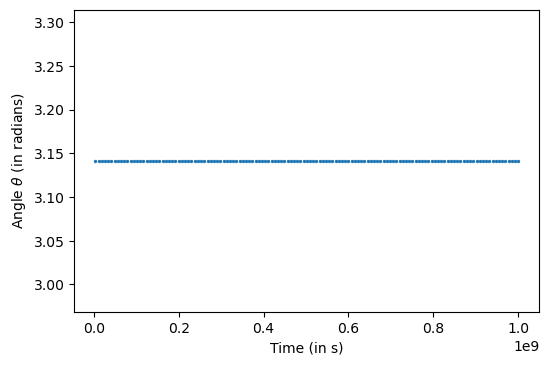

In [19]:
#Expected theta vs t graph for Newtonian gravity

theta_exp_n = np.zeros_like(ptn) + np.pi
plt.scatter(ptn, theta_exp_n, s=2)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

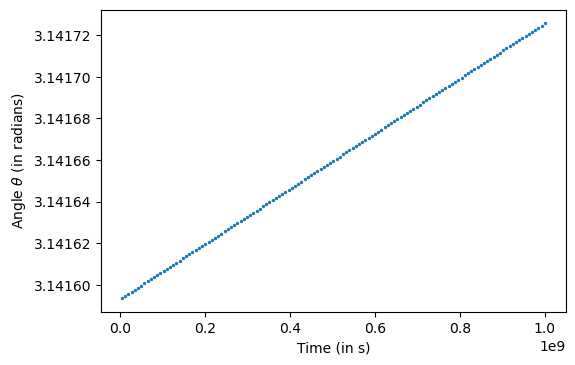

In [20]:
#Expected theta vs t graph for gravity with the addition of GR

theta_exp_e = np.zeros_like(pte) + np.pi + np.arange(1, len(pte)+1)/1000000
plt.scatter(pte, theta_exp_e, s=2)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel("Time (in s)")
plt.ylabel(r"Angle $\theta$ (in radians)")
plt.show()

# Proportionality of $k$ and precession rate

In [21]:
def kprop(k):
    ''' Simulates the orbit, finds the perihelions, and calculates the precession rate for a given value of k '''
    
    r, theta, t = solve(k=k)
    pr, pth, pthm, pt = peri(r, theta, t)
    m, c = np.polyfit(pt, pthm, 1)
    ppo, ppc = perirate(m, pt)
    
    return ppc

In [22]:
'''
This cell takes a while to run, and though I doubt it will kill the kernel, you could reduce the range of ks you test.
'''

ppcs = np.empty(20) #Array to contain precession rates
ks = np.empty(20)
for i in range(20):
    ks[i] = i
    ppcs[i] = kprop(i)

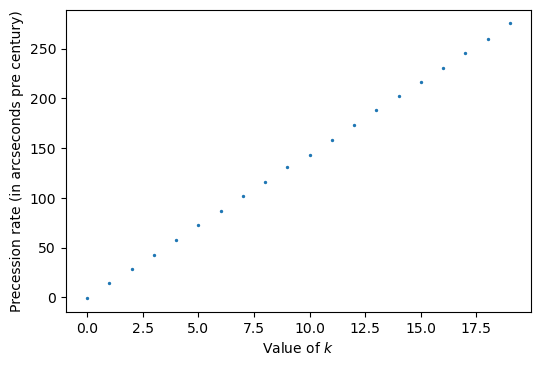

In [23]:
plt.scatter(ks, ppcs, s=2)
plt.xlabel('Value of $k$')
plt.ylabel('Precession rate (in arcseconds pre century)')
plt.show()

In [24]:
'''
Extrapolating each precession rate to the case where k = 3, 
By dividing by the corresponding value of k, then multiplying by 3
'''

true3 = np.zeros_like(ppcs)
for i in range(len(ppcs)):
    true3[i] = ppcs[i]*3/i
print(true3)

[       -inf 43.85565884 43.3676464  43.04907387 43.28380103 43.61512636
 43.48097253 43.45495825 43.33096707 43.57399155 42.93282834 43.2390831
 43.28555261 43.39118437 43.42305211 43.32551252 43.28176118 43.3746297
 43.36678253 43.48187672]


C:\Users\dhruv\AppData\Local\Temp/ipykernel_12488/3004222759.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  true3[i] = ppcs[i]*3/i


In [25]:
'''
Using only those cases where k is in the range of [10, 19] for extrapolation in the report.
Here the t vs theta graphs are less affected by numerical errors,
and are close enough to k = 0 & 3 to allow reasonable extrapolations.'''

true = true3[10:]
print(np.mean(true))
print(np.std(true))

43.31022631917541
0.14326110318685065
